# Greater venue diversity might be required as Ottawa gets ‘Ready for Rail’


## *Capstone Project - The Battle of the Neighborhoods (Week 2)*
### *Author: Macumber*

## Table of contents
* [1) Introduction: Business Problem](#introduction)
* [2) Data](#data)
    * [2.1) Find Station Locations](#locations)
    * [2.2) Foursquare Category Key](#key)
    * [2.3) Find Station Venues](#venues)
* [3) Methodology](#methodology)
* [4) Analysis](#analysis)
    * [4.1) Box Plots of Venue Categories](#boxplots)
    * [4.2) Cluster Analysis of Venue Categories](#clusters)
    * [4.3) Decision Tree Analysis of Venue Categories](#decisiontree)
* [5) Results](#results)
* [6) Discussion](#discussion)
* [7) Conclusion](#conclusion)

## 1) Introduction: Business Problem <a name="introduction"></a>


With the eminent opening of the new light rail transit system - The Confederation Line - Canada's capital, Ottawa, Ontario, is set to complete its largest transportation infrastructure project since the building of the Rideau Canal. With an expected increase in commuter traffic at rail stations along the Confederation Line it would be of interest to **know how the venues around the stations might change**. For example, is there a need for more Food venues at some of the stations. This information is of value **to small business owners looking for suitable locations**.

We can gain some insight into how venues might change by **comparing the types of venues around Ottawa stations** on the Confederation Line, to **types of venues around stations on a much older and more developed rail line**. Line 1 in Toronto, Ontario was opened in 1954 and is one of the busiest lines in North America.

Around each station we can assess the current proportion of each venue type (e.g., Food, Arts & Entertainment, Professional) and then compare each stations proportion to see if any differences exist, specifically between the Ottawa stations and the Toronto stations. Any major differences in the proportions of venue types could represent valuable targets for small business owners or companies to establish new ventures near Ottawa stations.

## 2) Data <a name="data"></a>

The Confederation Line is comprised of twelve stations while Line 1 has thirty-eight stations. I chose a subset of fourteen Line 1 stations, representing the original line opened in 1954 from Yonge to Spadina.

The Foursquare API was used to find all venues within a five-minute walking distance (416 m) of each station and collect the venue category (e.g., Food, Arts & Entertainment, College & University).

The Foursquare API uses over 900 subcategories for venues, which would make it difficult to do a general comparison between stations as some categories can be quite specific and not found at all stations. A category key was needed that translated all categories returned by the Foursquare API to one of the ten parent categories.

Using the venue category data and the category key proportions of each venue type (parent category) were generated for each station. This was then used for statistical analyses to compare differences and similarities between the proportions of venue types at rail stations.


### 2.1) Find Metro Station Locations <a name="locations"></a>

The first step is to get the Latitude and Longitude for all the Ottawa and Toronto stations.

**Import Libraries**

In [63]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt # scripting interface
import matplotlib.cm as cm
import matplotlib.image as mpimg
%matplotlib inline
mpl.style.use('ggplot') # ggplot-like style

# Use sklearn library for preprocessing/transforming data
from sklearn import preprocessing # normalize dataset
from sklearn.preprocessing import RobustScaler # dealing with outliers
from sklearn.preprocessing import MinMaxScaler # normalize dataset

# Scipy for cluster analysis
import scipy # scipy clustering
import pylab # scipy clustering
from scipy.cluster import hierarchy # scipy clustering
from scipy.cluster.hierarchy import fcluster
from scipy.spatial import distance_matrix # SCIKIT cluster
from scipy import ndimage

# Sklearn for cluster analysis
from sklearn.cluster import AgglomerativeClustering

# sklearn for decision tree model
from sklearn.tree import DecisionTreeClassifier

# visualize the decision tree
## in anaconda prompt install
## pip install pydotplus
## pip install graphviz
from sklearn.externals.six import StringIO
import pydotplus
from sklearn import tree  
from IPython.display import Image  
from sklearn.tree import export_graphviz

print('Libraries imported.')

Libraries imported.


**Create the list of the metro stations**

In [2]:
Station_Names = ['Blair Station Ottawa ON',
                  'Cyrville Station Ottawa ON',
                  'St-Laurent Station Ottawa ON',
                  'Tremblay Station Ottawa ON',
                  'Hurdman Station Ottawa ON',
                  'Lees Station Ottawa ON',
                  'uOttawa Station Ottawa ON',
                  'Rideau Station Ottawa ON',
                  #'Parliament Station Ottawa ON', # this station is not in the database
                  'Lyon Station Ottawa ON',
                  'Pimisi Station Ottawa ON',
                  'Bayview Station Ottawa ON',
                   'Bloor-Yonge Station Toronto ON',
                   'Wellesley Station Toronto ON',
                   'College Station Toronto ON',
                   'Dundas Station Toronto ON',
                   'Queen Station Toronto ON',
                   'King Station Toronto ON',
                   'Union Station Toronto ON',
                   'St-Andrew Station Toronto ON',
                   'Osgoode Station Toronto ON',
                   'St-Patrick Station Toronto ON',
                   'Queens Park Station Toronto ON',
                   'Museum Station Toronto ON',
                   'St-George Station Toronto ON',
                   'Spadina Station Toronto ON']

**Create Empty Dataframe**

In [3]:
# define the dataframe columns
column_names = ['City', 'Station', 'Latitude', 'Longitude'] 

# instantiate the dataframe
Stations = pd.DataFrame(columns=column_names)

# have a look
Stations

,City,Station,Latitude,Longitude


**Append Station Data**

Here we will use the Nominatim() function to return the latitude and longitude of our stations. We will then add the info to the empty dataframe (Stations) we just created.

In [4]:
for name in Station_Names:
    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(name)
    latitude = location.latitude
    longitude = location.longitude
    #print('The geographical coordinate of the {} are {}, {}.'.format(name,latitude, longitude))
    
    name_split = name.split()
    
    City = name_split[-2]
    Station = name_split[0]
    
    Stations = Stations.append({'City': City,
                                'Station': Station,
                                'Latitude': latitude,
                                'Longitude': longitude}, ignore_index=True)
    
# Have a look
Stations.head()

,City,Station,Latitude,Longitude
0,Ottawa,Blair,45.431026,-75.608416
1,Ottawa,Cyrville,45.422745,-75.626372
2,Ottawa,St-Laurent,45.420605,-75.638188
3,Ottawa,Tremblay,45.416933,-75.653348
4,Ottawa,Hurdman,45.412335,-75.664425


**Fix Errors In Table**

In [5]:
# Queens is actually Queen's Park
Stations.iloc[21,1] = 'Queen\'s Park'

# Parliament Station is not in the Nominatum dataset. We need to add it manually
Stations = Stations.append({'City': 'Ottawa',
                                'Station': 'Parliament',
                                'Latitude': 45.421389,
                                'Longitude': -75.698889}, ignore_index=True)

**The Final Table**

In [6]:
Stations

,City,Station,Latitude,Longitude
0,Ottawa,Blair,45.431026,-75.608416
1,Ottawa,Cyrville,45.422745,-75.626372
2,Ottawa,St-Laurent,45.420605,-75.638188
3,Ottawa,Tremblay,45.416933,-75.653348
4,Ottawa,Hurdman,45.412335,-75.664425
5,Ottawa,Lees,45.416285,-75.670533
6,Ottawa,uOttawa,45.420677,-75.682466
7,Ottawa,Rideau,45.327995,-75.701521
8,Ottawa,Lyon,45.418518,-75.705015
9,Ottawa,Pimisi,45.413592,-75.713726


**Write File**

In [10]:
Stations.to_csv('Stations.csv', index = None)

### 2.2) Foursquare Category Key <a name="key"></a>

Next we need to create a table that can be used as a key to convert any Foursquare (sub)categories back to its main category heading. For example, "Italian Restaurant" to "Food".

**Define Foursquare Credentials**

In [7]:
#CLIENT_ID = [hidden] # your Foursquare ID
#CLIENT_SECRET = [hidden] # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version

CLIENT_ID = 'IP5SLL30YW00QF4AF4WCUSTRX4FHKJZGGYMRHFXNFN1TCYPM' # your Foursquare ID
CLIENT_SECRET = 'BTECFQLVC11ZLJPRVKA1S3YNYHXOZRS02U5W4ZB4WJP33HWB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
#url

**Make a request to Foursquare API**

We will request the complete list of Foursquare categories.

In [8]:
category_tree_json = requests.get(url).json()

#print(type(category_tree_json))
#category_tree_json

**Parent Category Names**


We will grouping all sub-categories to this level. So we need to create a reference list of the parent categories.

In [9]:
FirstLevel = []

for category in category_tree_json['response']['categories']:
    #print(category['name'])
    FirstLevel.append(category['name'])
    
FirstLevel

['Arts & Entertainment',
 'College & University',
 'Event',
 'Food',
 'Nightlife Spot',
 'Outdoors & Recreation',
 'Professional & Other Places',
 'Residence',
 'Shop & Service',
 'Travel & Transport']

**All Categories**


Create a list that includes all (sub)category names. First the parent category is listed and then this is followed by all sub-categories. After all sub-categories from the parent are listed a blank element is added to the list. This is followed by the next parent category, and so on.

In [10]:
# Create an empty list to story category names
FourthLevel = []

# Create a list that will go through the category tree json and extract each level of category
for category in category_tree_json['response']['categories']:
    #print(category['name'])
    FourthLevel.append(category['name'])
    Sub1 = category['categories']
    for category1 in Sub1:
        #print(category1['name'])
        FourthLevel.append(category1['name'])
        Sub2 = list(category1['categories'])
        for category2 in Sub2:
            #print(category2['name'])
            FourthLevel.append(category2['name'])
            Sub3 = category2['categories']
            for category3 in Sub3:
                #print(category3['name'])
                FourthLevel.append(category3['name'])
    FourthLevel.append(' ')

# How many categories in the Foursquare category tree?
print('There are {} categories in the Foursquare category tree.'.format(len(FourthLevel)))

There are 934 categories in the Foursquare category tree.


**Create a List of Subcategories for each Parent Category**

Using the blank element inserted following the last parent subcategory, we can break our single list into multiple lists. Each of the sublists will be specific to one of the ten parent categories.

First step was to define a function for creating a list of lists.

In [11]:
# Code source:
# https://www.reddit.com/r/learnpython/comments/3sk1xj/splitting_a_list_in_sublists_by_values/

def split_list(iterable, splitters):

    #Find index of each splitter value in the list
    indexes = []
    for splitter in sorted(splitters):
        try:
            split = iterable.index(splitter)
            indexes.append(split)
        except ValueError:
            #Splitter not found in list
            pass

    #Split the iterable into sublists based on indices
    split_lists = []
    start = 0
    for index in sorted(indexes):
        split_lists.append(iterable[start:index])
        start = index
    split_lists.append(iterable[start:])

    return split_lists

**Apply the Splitting Function**

In [13]:
# The first element in each sublist will be the parent category
splitters = (FirstLevel)

# Apply the splitting function
FourSqKey_broken = split_list(iterable = FourthLevel, splitters = splitters)

# Remove the first element which is blank
del FourSqKey_broken[0]

# There should be 10 sublists one for each parent category
print('There were {} out of 10 sublists split.'.format(len(FourSqKey_broken)))

There were 10 out of 10 sublists split.


**Create the Category Key**

For each category in the sublist we will associate the category with its Parent Category (first element in sublist). This will create a dataframe with Parent and Categories columns. We can then use it as our key to convert any Foursquare category back to its parent category.

In [14]:
columns = ['Parent', 'categories']

CategoryKey = pd.DataFrame(columns=columns)

for i in FourSqKey_broken:
    for y in i:
        #print('CategoryKey')
        #print(CategoryKey)
        temp_parent = i[0]
        temp_daughter = y
        CategoryKey = CategoryKey.append({'Parent':temp_parent, 'categories': temp_daughter}, ignore_index = True)
    

**Final Category Key**

In [15]:
CategoryKey.head()

,Parent,categories
0,Arts & Entertainment,Arts & Entertainment
1,Arts & Entertainment,Amphitheater
2,Arts & Entertainment,Aquarium
3,Arts & Entertainment,Arcade
4,Arts & Entertainment,Art Gallery


**Write File**

In [24]:
CategoryKey.to_csv('CategoryKey.csv', index = None)

### 2.3) Find Station Venues <a name="venues"></a>

Extract venue information for all stations in Ottawa and Toronto.

**Define Function To Extract Categories From Venues**

In [16]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

**Make Foursquare API Request For Station Venues and Add Parent Categories**

In [17]:
Station_dfs = {}

NumberOfVenues = [] # a list of total venues at each station; empty
NumberOfUniqueCategories = [] #a list of unique categories at each station; empty
AllCategories = [] # a list of all subcategories in the dataset

radius = 416 # in meters; 5 min walk
LIMIT = 1000


for i in range(Stations.shape[0]):
        
    latitude = Stations.iloc[i,2]
    longitude = Stations.iloc[i,3]
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    
    results = requests.get(url).json()
    
    venues = results['response']['venues']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['name', 'categories', 'location.lat', 'location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    
    print('{} venues were returned by Foursquare for {}.'.format(nearby_venues.shape[0], Stations.iloc[i,1]))
    
    # Add the total number of venues at this station to NumberOfVenues list
    NumberOfVenues.append(nearby_venues.shape[0])
    
    # Add the total number of unique categories to the NumberOfCategories list
    NumberOfUniqueCategories.append(len(set(nearby_venues['categories'])))
    
    # Add all categories returned to the AllCategories list
    AllCategories.append(nearby_venues['categories'].tolist())
    
    nearby_venues_parent = nearby_venues.merge(CategoryKey, on = 'categories')
    
    Station_dfs[Stations.iloc[i,1]] =nearby_venues_parent.groupby(['Parent']).size()
    
    

105 venues were returned by Foursquare for Blair.
104 venues were returned by Foursquare for Cyrville.
195 venues were returned by Foursquare for St-Laurent.
85 venues were returned by Foursquare for Tremblay.
125 venues were returned by Foursquare for Hurdman.
106 venues were returned by Foursquare for Lees.
131 venues were returned by Foursquare for uOttawa.
90 venues were returned by Foursquare for Rideau.
191 venues were returned by Foursquare for Lyon.
188 venues were returned by Foursquare for Pimisi.
184 venues were returned by Foursquare for Bayview.
200 venues were returned by Foursquare for Bloor-Yonge.
190 venues were returned by Foursquare for Wellesley.
175 venues were returned by Foursquare for College.
199 venues were returned by Foursquare for Dundas.
198 venues were returned by Foursquare for Queen.
199 venues were returned by Foursquare for King.
97 venues were returned by Foursquare for Union.
200 venues were returned by Foursquare for St-Andrew.
188 venues were retu

**Find out the total number of unique categories and by city**

In [18]:
## Create a list of the index position of stations belonging to a specific city
OttawaStations = [0,1,2,3,4,5,6,7,8,9,10,25]
TorontoStations = [11,12,13,14,15,16,17,18,19,20,21,22,23,24]


## create a method for non-contiguous slicing of lists
## code source: https://bugs.python.org/issue419903
def dice(a, b):
    return [ a[x] for x in b ]


## Create lists of categories specific to city
OttawaCategories = dice(AllCategories, OttawaStations)
TorontoCategories = dice(AllCategories, TorontoStations)


## How many unique categories for all stations
AllCategories_flatlist = []
for sublist in AllCategories:
    for item in sublist:
        AllCategories_flatlist.append(item)

print('A total of {} unique categories were returned by Foursquare.'.format(len(set(AllCategories_flatlist))))


## How many unique categories for Ottawa stations
OttawaCategories_flatlist = []
for sublist in OttawaCategories:
    for item in sublist:
        OttawaCategories_flatlist.append(item)

print('A total of {} unique categories were returned for Ottawa Stations by Foursquare.'.format(len(set(OttawaCategories_flatlist))))


## How many unique categories for Toronto stations
TorontoCategories_flatlist = []
for sublist in TorontoCategories:
    for item in sublist:
        TorontoCategories_flatlist.append(item)

print('A total of {} unique categories were returned for Toronto Stations by Foursquare.'.format(len(set(TorontoCategories_flatlist))))

A total of 393 unique categories were returned by Foursquare.
A total of 290 unique categories were returned for Ottawa Stations by Foursquare.
A total of 321 unique categories were returned for Toronto Stations by Foursquare.


**Create a Dataframe of Category Counts**

Merge all the station category counts into a single dataframe.

In [19]:
keys = list(Station_dfs.keys())

Stations_VenueCounts = pd.Series([])

for i in range(len(keys)):
    #print(i)
    #print(Station_dfs[keys[i]])
    Stations_VenueCounts = pd.concat([Stations_VenueCounts, Station_dfs[keys[i]]], axis=1, sort=True)
    #print(Stations_VenueCounts)

Stations_VenueCounts

,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arts & Entertainment,NaN,1.0,2.0,3.0,2.0,2.0,3.0,1.0,NaN,2.0,24,10,2.0,6.0,6.0,15.0,9.0,4.0,4.0,4.0,11.0,3.0,3.0,37.0,11.0,4.0,3.0
College & University,NaN,1.0,NaN,1.0,1.0,11.0,13.0,83.0,1.0,4.0,2,1,5.0,2.0,3.0,6.0,NaN,2.0,NaN,3.0,1.0,5.0,19.0,36.0,23.0,12.0,NaN
Event,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Food,NaN,26.0,8.0,35.0,16.0,15.0,15.0,11.0,13.0,25.0,34,25,25.0,41.0,36.0,59.0,36.0,31.0,23.0,39.0,31.0,46.0,35.0,14.0,12.0,25.0,28.0
Nightlife Spot,NaN,1.0,2.0,NaN,NaN,3.0,3.0,4.0,2.0,4.0,2,11,2.0,10.0,4.0,5.0,6.0,7.0,4.0,5.0,8.0,2.0,1.0,4.0,4.0,5.0,5.0
Outdoors & Recreation,NaN,4.0,2.0,1.0,4.0,14.0,11.0,6.0,7.0,7.0,21,10,5.0,5.0,6.0,10.0,3.0,7.0,1.0,4.0,15.0,4.0,3.0,12.0,4.0,6.0,6.0
Professional & Other Places,NaN,20.0,30.0,7.0,13.0,16.0,14.0,8.0,41.0,82.0,30,42,92.0,26.0,42.0,41.0,31.0,84.0,17.0,96.0,61.0,82.0,80.0,34.0,37.0,43.0,68.0
Residence,NaN,NaN,2.0,NaN,NaN,14.0,9.0,2.0,NaN,4.0,12,9,1.0,17.0,11.0,NaN,1.0,1.0,NaN,2.0,7.0,11.0,NaN,NaN,3.0,4.0,1.0
Shop & Service,NaN,35.0,36.0,133.0,20.0,15.0,10.0,5.0,15.0,21.0,28,51,49.0,61.0,44.0,47.0,98.0,37.0,12.0,29.0,15.0,28.0,23.0,14.0,13.0,24.0,34.0
Travel & Transport,NaN,10.0,11.0,1.0,24.0,26.0,16.0,4.0,5.0,28.0,16,11,8.0,11.0,10.0,5.0,7.0,14.0,29.0,12.0,25.0,8.0,6.0,5.0,7.0,61.0,5.0


Add Station Names and Transpose

In [20]:
## Column Names ##
# Give a title to first column
col01 = 'col01'

# Create a list of column name for the Stations_VenueCounts dataframe
column_names = [col01] + keys

# Assign column names to Stations_VenueCounts dataframe
Stations_VenueCounts.columns = [column_names]


## Drop First Empty Column ##
Stations_VenueCounts = Stations_VenueCounts.drop('col01', axis=1)

    
## Transpose the dataframe ##
Stations_VenueCounts = Stations_VenueCounts.transpose()

C:\DataScience\lib\site-packages\pandas\core\generic.py:3111: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Drop Columns

In [21]:
## Drop Events Column. Greater than 25% NaNs ##
Stations_VenueCounts = Stations_VenueCounts.drop('Event', axis=1)


## Drop Residence Column. Greater than 25% NaNs ##
Stations_VenueCounts = Stations_VenueCounts.drop('Residence', axis=1)

Replace NaNs

In [22]:
## Replace NaN with 0s
Stations_VenueCounts = Stations_VenueCounts.fillna(0)

Add Columns

In [23]:
## Add total venue count for each station
Stations_VenueCounts['Total Venues'] = NumberOfVenues

## Add total number of unique categories for each station
Stations_VenueCounts['Unique Categories'] = NumberOfUniqueCategories

## Add city column
Stations_VenueCounts['City'] = Stations['City'].values # series with different index

## Add Latitude column
Stations_VenueCounts['Latitude'] = Stations['Latitude'].values # series with different index

## Add Longitude column
Stations_VenueCounts['Longitude'] = Stations['Longitude'].values # series with different index

Reorder Columns

In [24]:
Stations_VenueCounts = Stations_VenueCounts[[
    'City',
    'Latitude',
    'Longitude',
    'Arts & Entertainment',
    'College & University',
    'Food',
    'Nightlife Spot',
    'Outdoors & Recreation',
    'Professional & Other Places',
    'Shop & Service',
    'Travel & Transport',
    'Total Venues',
    'Unique Categories'
]]

**Final Dataframe: Stations Category Counts**

In [25]:
Stations_VenueCounts_Sorted = Stations_VenueCounts.rename_axis('Station').sort_values(by = ['City', 'Station'], ascending = [True, True])
Stations_VenueCounts_Sorted

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Total Venues,Unique Categories
Station,,,,,,,,,,,,,
Bayview,Ottawa,45.409230,-75.722323,10.0,1.0,25.0,11.0,10.0,42.0,51.0,11.0,184,99
Blair,Ottawa,45.431026,-75.608416,1.0,1.0,26.0,1.0,4.0,20.0,35.0,10.0,105,63
Cyrville,Ottawa,45.422745,-75.626372,2.0,0.0,8.0,2.0,2.0,30.0,36.0,11.0,104,60
Hurdman,Ottawa,45.412335,-75.664425,2.0,11.0,15.0,3.0,14.0,16.0,15.0,26.0,125,62
Lees,Ottawa,45.416285,-75.670533,3.0,13.0,15.0,3.0,11.0,14.0,10.0,16.0,106,61
Lyon,Ottawa,45.418518,-75.705015,2.0,4.0,25.0,4.0,7.0,82.0,21.0,28.0,191,73
Parliament,Ottawa,45.421389,-75.698889,3.0,0.0,28.0,5.0,6.0,68.0,34.0,5.0,158,69
Pimisi,Ottawa,45.413592,-75.713726,24.0,2.0,34.0,2.0,21.0,30.0,28.0,16.0,188,89
Rideau,Ottawa,45.327995,-75.701521,0.0,1.0,13.0,2.0,7.0,41.0,15.0,5.0,90,50


**Write File**

In [62]:
Stations_VenueCounts_Sorted.to_csv('Stations_VenueCounts.csv', index = True)

## 3) Methodology <a name="methodology"></a>

In this project we will investigate the proportions of venue categories around metro stations in Ottawa and Toronto, Ontario. We will limit our analysis to an area ~400m (i.e., 5 minute walk) around each station.

In first step we have collected the required **data: location and category of every venue within 416m from each station**.

Second step in our analysis will be to exploration of the '**category distributions**' - we will use **boxplots** to illustrate the range of venue type proportions for each parent category, this will highlight categories with large amounts of variability and outliers.

In third step we will create **clusters of stations** based on venue type proportions. We will present a dendrogram using **hierarchical clustering** (i.e., complete linkage) and pay close attention to the ratio of Toronto to Ottawa stations in each cluster. 

In the fourth and final step we will use a **decision tree model** fitted with the venue type proportions. This will give insight into important venue categories for each cluster. This information will help with recommendations for what types of venues might be needed at Ottawa stations.

## 4) Analysis <a name="analysis"></a>


### 4.1) Box Plots of Venue Categories <a name="boxplots"></a>


Let's look at how stations vary in the percent of each venue cateogry.

**Convert to Percentage**


Convert the venue category count to percentage of total venues at each Station

In [58]:
boxplot_000 = Stations_VenueCounts_Sorted.iloc[:,3:11]

boxplot_001 = boxplot_000.div(boxplot_000.sum(1), 0).round(2)
boxplot_002 = boxplot_001*100

boxplot_002

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Station,,,,,,,,
Bayview,6.0,1.0,16.0,7.0,6.0,26.0,32.0,7.0
Blair,1.0,1.0,27.0,1.0,4.0,20.0,36.0,10.0
Cyrville,2.0,0.0,9.0,2.0,2.0,33.0,40.0,12.0
Hurdman,2.0,11.0,15.0,3.0,14.0,16.0,15.0,25.0
Lees,4.0,15.0,18.0,4.0,13.0,16.0,12.0,19.0
Lyon,1.0,2.0,14.0,2.0,4.0,47.0,12.0,16.0
Parliament,2.0,0.0,19.0,3.0,4.0,46.0,23.0,3.0
Pimisi,15.0,1.0,22.0,1.0,13.0,19.0,18.0,10.0
Rideau,0.0,1.0,15.0,2.0,8.0,49.0,18.0,6.0


**Box Plots**

Let's take a look at the category distribution over all stations using box plots.

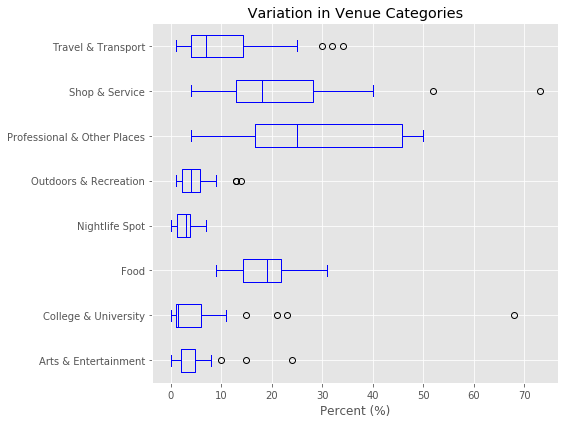

In [29]:
boxplot_002.plot(kind = 'box',
              figsize=(8, 6),
              color = 'blue',
              vert = False # if you prefer horizontal
             )

plt.title(' Variation in Venue Categories ')
plt.xlabel('Percent (%)')

plt.tight_layout()

plt.savefig('Macumber_Coursera_Capstone_Figure01.png') # has to be before plt.show()

plt.show()

*The **Professional & Other Places** and **Shop & Service** venues had the greatest range of values. Several **outliers** were identified (black circles), but the majority fall within the range of other category distributions, apart from two extreme outliers in **Shops & Service** and **College & University** categories*.

**Final Dataframe**

In [31]:
Stations_VenueCounts_tomerge = Stations_VenueCounts_Sorted[['City', 'Latitude', 'Longitude']]

Stations_VenueCounts_Percent = Stations_VenueCounts_tomerge.merge(boxplot_002, left_index = True, right_index = True)

Stations_VenueCounts_Percent

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Station,,,,,,,,,,,
Bayview,Ottawa,45.409230,-75.722323,6.0,1.0,16.0,7.0,6.0,26.0,32.0,7.0
Blair,Ottawa,45.431026,-75.608416,1.0,1.0,27.0,1.0,4.0,20.0,36.0,10.0
Cyrville,Ottawa,45.422745,-75.626372,2.0,0.0,9.0,2.0,2.0,33.0,40.0,12.0
Hurdman,Ottawa,45.412335,-75.664425,2.0,11.0,15.0,3.0,14.0,16.0,15.0,25.0
Lees,Ottawa,45.416285,-75.670533,4.0,15.0,18.0,4.0,13.0,16.0,12.0,19.0
Lyon,Ottawa,45.418518,-75.705015,1.0,2.0,14.0,2.0,4.0,47.0,12.0,16.0
Parliament,Ottawa,45.421389,-75.698889,2.0,0.0,19.0,3.0,4.0,46.0,23.0,3.0
Pimisi,Ottawa,45.413592,-75.713726,15.0,1.0,22.0,1.0,13.0,19.0,18.0,10.0
Rideau,Ottawa,45.327995,-75.701521,0.0,1.0,15.0,2.0,8.0,49.0,18.0,6.0


**Export the file**

In [15]:
Stations_VenueCounts_Percent.to_csv('Stations_VenueCounts_Percent.csv')

### 4.2) Cluster Analysis of Venue Categories <a name="clusters"></a>

Visualise which stations cluster together based on their venue categories.

**Distance Matrix**


First we need to convert our dataframe to a distance matrix.

In [47]:
## take only venue category percents
cluster_000 = Stations_VenueCounts_Percent
cluster_001 = cluster_000.iloc[:,3:11]

## calculate the distance matrix
dist_matrix = distance_matrix(cluster_001, cluster_001)

## take a look
dist_matrix

array([[ 0.        , 15.71623365, 15.65247584, 30.16620626, 30.09983389,
        31.32091953, 23.3023604 , 21.3541565 , 28.14249456, 47.95831523,
        27.5680975 , 75.76938696, 25.63201124, 10.09950494, 18.1934054 ,
        23.15167381, 37.92097045, 27.14774392, 23.49468025, 31.09662361,
        34.278273  , 30.5122926 , 30.06659276, 28.93095228, 34.2636834 ,
        15.19868415],
       [15.71623365,  0.        , 22.8035085 , 32.10918872, 32.38826948,
        38.88444419, 31.04834939, 25.03996805, 36.6469644 , 42.20189569,
        24.2693222 , 77.84600182, 34.3220046 , 12.04159458, 15.74801575,
        31.54362059, 46.24932432, 34.40930107, 19.92485885, 37.28270376,
        36.49657518, 37.62977544, 38.82009789, 33.49626845, 32.29551052,
         8.24621125],
       [15.65247584, 22.8035085 ,  0.        , 37.21558813, 39.45883931,
        32.09361307, 25.37715508, 33.83784863, 29.20616373, 46.44351408,
        31.19294792, 81.7801932 , 23.32380758, 20.22374842, 31.08054054,
       

**Cluster analysis**

Let's perform a complete linkage hierarchical cluster analysis using the distance matrix.

In [39]:
Z = hierarchy.linkage(dist_matrix, 'complete')

C:\DataScience\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


**Visualization**

Let's take a look at the dendrogram.

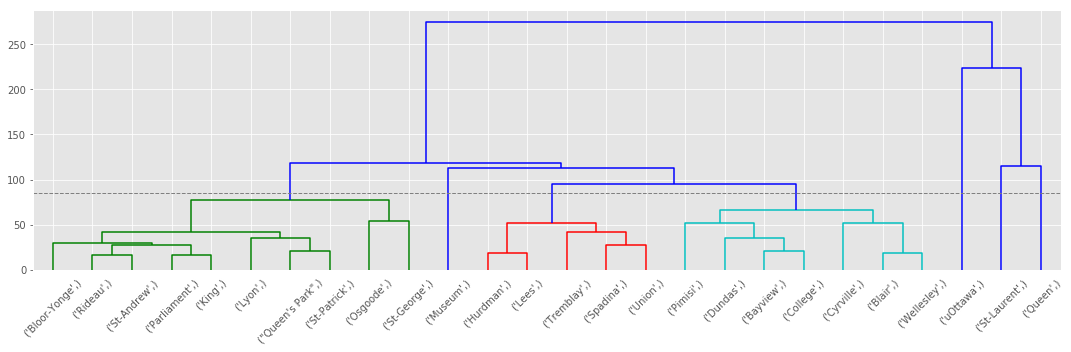

In [42]:
## initiate and define size of figure
fig = pylab.figure(figsize=(15,5))

## plot the dendrogram
dendro = hierarchy.dendrogram(Z, labels = cluster_000.index, color_threshold = 85)

## show the cutoff line
plt.axhline(y=85, c='grey', lw=1, linestyle='dashed')

## export the file as a png
plt.tight_layout()
plt.savefig('Macumber_Coursera_Capstone_Figure02.png') # has to be before plt.show()

_Based on the above figure the majority of stations cluster at distances <50. This level would result in eight clusters with only one member. Increasing the cut-off to 85 reduces the number of clusters with only one member to four. Thus we have selected 7 clusters for the final result._

**Generate Cluster Labels & Final Dataframe**

In [50]:
## run cluster analysis using sklearn
agglom = AgglomerativeClustering(n_clusters = 7, linkage = 'complete')
agglom.fit(dist_matrix)

## look at the cluster labels
print(agglom.labels_)

## add the cluster labels to the dataframe
cluster_000['Cluster']=agglom.labels_ #with City, Latitude and Longitude
cluster_001['Cluster']=agglom.labels_ #removed City, Latitude and Longitude

## the final dataframe
cluster_002 = cluster_000.sort_values(by = ['Cluster', 'City'])
cluster_002 # with City, Latitude and Longitude: sorted by Cluster, City

[1 1 1 2 2 0 0 1 0 4 2 5 0 1 1 0 6 0 3 0 2 0 0 0 2 1]


C:\DataScience\lib\site-packages\sklearn\cluster\hierarchical.py:471: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
Lyon,Ottawa,45.418518,-75.705015,1.0,2.0,14.0,2.0,4.0,47.0,12.0,16.0,0
Parliament,Ottawa,45.421389,-75.698889,2.0,0.0,19.0,3.0,4.0,46.0,23.0,3.0,0
Rideau,Ottawa,45.327995,-75.701521,0.0,1.0,15.0,2.0,8.0,49.0,18.0,6.0,0
Bloor-Yonge,Toronto,43.670812,-79.386847,1.0,3.0,13.0,1.0,3.0,49.0,26.0,4.0,0
King,Toronto,43.648523,-79.377773,2.0,1.0,17.0,4.0,4.0,45.0,20.0,8.0,0
Osgoode,Toronto,43.650802,-79.386541,7.0,1.0,19.0,5.0,9.0,37.0,9.0,15.0,0
Queen's Park,Toronto,43.659980,-79.390369,2.0,11.0,21.0,1.0,2.0,47.0,14.0,4.0,0
St-Andrew,Toronto,43.647792,-79.384871,2.0,2.0,20.0,3.0,2.0,50.0,15.0,6.0,0
St-George,Toronto,43.668641,-79.398019,10.0,21.0,11.0,4.0,4.0,33.0,12.0,6.0,0


**Cluster Category Averages**

In [60]:
## Look at mean category percentages by cluster
cluster_003 = cluster_001.groupby('Cluster').mean().round(1)
cluster_003 # City, Latitude, Longitude removed: sorted by Cluster

,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
Cluster,,,,,,,,
0,2.9,4.5,17.5,2.6,4.2,44.9,16.5,7.2
1,5.7,1.3,22.0,3.3,5.3,23.4,31.1,8.0
2,2.8,6.8,18.6,2.8,7.2,18.2,15.6,28.0
3,5.0,0.0,19.0,3.0,2.0,16.0,52.0,4.0
4,2.0,1.0,19.0,0.0,1.0,4.0,73.0,1.0
5,1.0,68.0,9.0,3.0,5.0,7.0,4.0,3.0
6,24.0,23.0,9.0,3.0,8.0,22.0,9.0,3.0


*Each cluster is characterised by one or a few categories. For example, cluster 3 is characterised by a high percent (64%) of **College & University** venues.*

**Examine Members of Each Cluster**

In [51]:
cluster_002.loc[cluster_002['Cluster'] == 0]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
Lyon,Ottawa,45.418518,-75.705015,1.0,2.0,14.0,2.0,4.0,47.0,12.0,16.0,0
Parliament,Ottawa,45.421389,-75.698889,2.0,0.0,19.0,3.0,4.0,46.0,23.0,3.0,0
Rideau,Ottawa,45.327995,-75.701521,0.0,1.0,15.0,2.0,8.0,49.0,18.0,6.0,0
Bloor-Yonge,Toronto,43.670812,-79.386847,1.0,3.0,13.0,1.0,3.0,49.0,26.0,4.0,0
King,Toronto,43.648523,-79.377773,2.0,1.0,17.0,4.0,4.0,45.0,20.0,8.0,0
Osgoode,Toronto,43.650802,-79.386541,7.0,1.0,19.0,5.0,9.0,37.0,9.0,15.0,0
Queen's Park,Toronto,43.659980,-79.390369,2.0,11.0,21.0,1.0,2.0,47.0,14.0,4.0,0
St-Andrew,Toronto,43.647792,-79.384871,2.0,2.0,20.0,3.0,2.0,50.0,15.0,6.0,0
St-George,Toronto,43.668641,-79.398019,10.0,21.0,11.0,4.0,4.0,33.0,12.0,6.0,0


*Cluster 0 contains **3 Ottawa Stations** and **7 Toronto** for a total of 10 stations. They are characterised by a higher percentage of **Professional & Other Places** venues.*

In [52]:
cluster_002.loc[cluster_002['Cluster'] == 1]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
Bayview,Ottawa,45.409230,-75.722323,6.0,1.0,16.0,7.0,6.0,26.0,32.0,7.0,1
Blair,Ottawa,45.431026,-75.608416,1.0,1.0,27.0,1.0,4.0,20.0,36.0,10.0,1
Cyrville,Ottawa,45.422745,-75.626372,2.0,0.0,9.0,2.0,2.0,33.0,40.0,12.0,1
Pimisi,Ottawa,45.413592,-75.713726,15.0,1.0,22.0,1.0,13.0,19.0,18.0,10.0,1
College,Toronto,43.660662,-79.382795,4.0,2.0,24.0,3.0,4.0,28.0,29.0,7.0,1
Dundas,Toronto,43.656537,-79.381022,8.0,3.0,31.0,3.0,5.0,22.0,25.0,3.0,1
Wellesley,Toronto,43.665403,-79.383600,4.0,1.0,25.0,6.0,3.0,16.0,38.0,7.0,1


*Cluster 1 contains **4 Ottawa Stations** and **3 Toronto** for a total of 7 stations. They are characterised by a higher percentage of **Shop & Service** venues.*

In [53]:
cluster_002.loc[cluster_002['Cluster'] == 2]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
Hurdman,Ottawa,45.412335,-75.664425,2.0,11.0,15.0,3.0,14.0,16.0,15.0,25.0,2
Lees,Ottawa,45.416285,-75.670533,4.0,15.0,18.0,4.0,13.0,16.0,12.0,19.0,2
Tremblay,Ottawa,45.416933,-75.653348,2.0,1.0,20.0,0.0,5.0,16.0,25.0,30.0,2
Spadina,Toronto,43.667235,-79.403686,2.0,7.0,14.0,3.0,3.0,24.0,13.0,34.0,2
Union,Toronto,43.644690,-79.379966,4.0,0.0,26.0,4.0,1.0,19.0,13.0,32.0,2


*Cluster 2 contains **3 Ottawa Stations** and **2 Toronto** for a total of 5 stations. They are characterised by a higher percentage of **Travel & Transport** venues.*

In [54]:
cluster_002.loc[cluster_002['Cluster'] == 3]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
Queen,Toronto,43.652908,-79.379458,5.0,0.0,19.0,3.0,2.0,16.0,52.0,4.0,3


*Cluster 3 contains **1 Toronto station** for a total of 1 stations. It is characterised by a higher percentage of **Shop & Service** venues.*

In [55]:
cluster_002.loc[cluster_002['Cluster'] == 4]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
St-Laurent,Ottawa,45.420605,-75.638188,2.0,1.0,19.0,0.0,1.0,4.0,73.0,1.0,4


*Cluster 4 contains **1 Ottawa station** for a total of 1 stations. It is characterised by a higher percentage of **Shop & Service** venues.*

In [56]:
cluster_002.loc[cluster_002['Cluster'] == 5]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
uOttawa,Ottawa,45.420677,-75.682466,1.0,68.0,9.0,3.0,5.0,7.0,4.0,3.0,5


*Cluster 5 contains **1 Ottawa station** for a total of 1 stations. It is characterised by a higher percentage of **College & University** venues.*

In [57]:
cluster_002.loc[cluster_002['Cluster'] == 6]

,City,Latitude,Longitude,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport,Cluster
Station,,,,,,,,,,,,
Museum,Toronto,43.667097,-79.393607,24.0,23.0,9.0,3.0,8.0,22.0,9.0,3.0,6


*Cluster 6 contains **1 Toronto station** for a total of 1 stations. It is characterised by a higher percentage of **Arts & Entertainment** venues.*

**Output the File**

In [61]:
cluster_002.to_csv('Stations_VenueCounts_Clustered.csv')
cluster_003.to_csv('Stations_VenueCounts_Clustered_Averaged.csv')

## 4.3) Decision Tree Model of Venue Category <a name="decisiontree"></a>


Let's fit the venue category percentages to a decision tree model to gain further insight into the importance of category proportions in grouping the stations together.

**Assign X and Y**

Define feature set X

In [64]:
tree_000 = cluster_002

X = tree_000[['Arts & Entertainment'
                                   , 'College & University'
                                   , 'Food'
                                   , 'Nightlife Spot'
                                   , 'Outdoors & Recreation'
                                   , 'Professional & Other Places'
                                   , 'Shop & Service'
                                   , 'Travel & Transport'
                                  ]].values

Define labels for the feature set

In [65]:
Y = tree_000['Cluster'].values

**Decision Tree Model**


Create an instance

In [67]:
dtree = DecisionTreeClassifier()

Fit the model

In [68]:
dtree.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Visualise the model

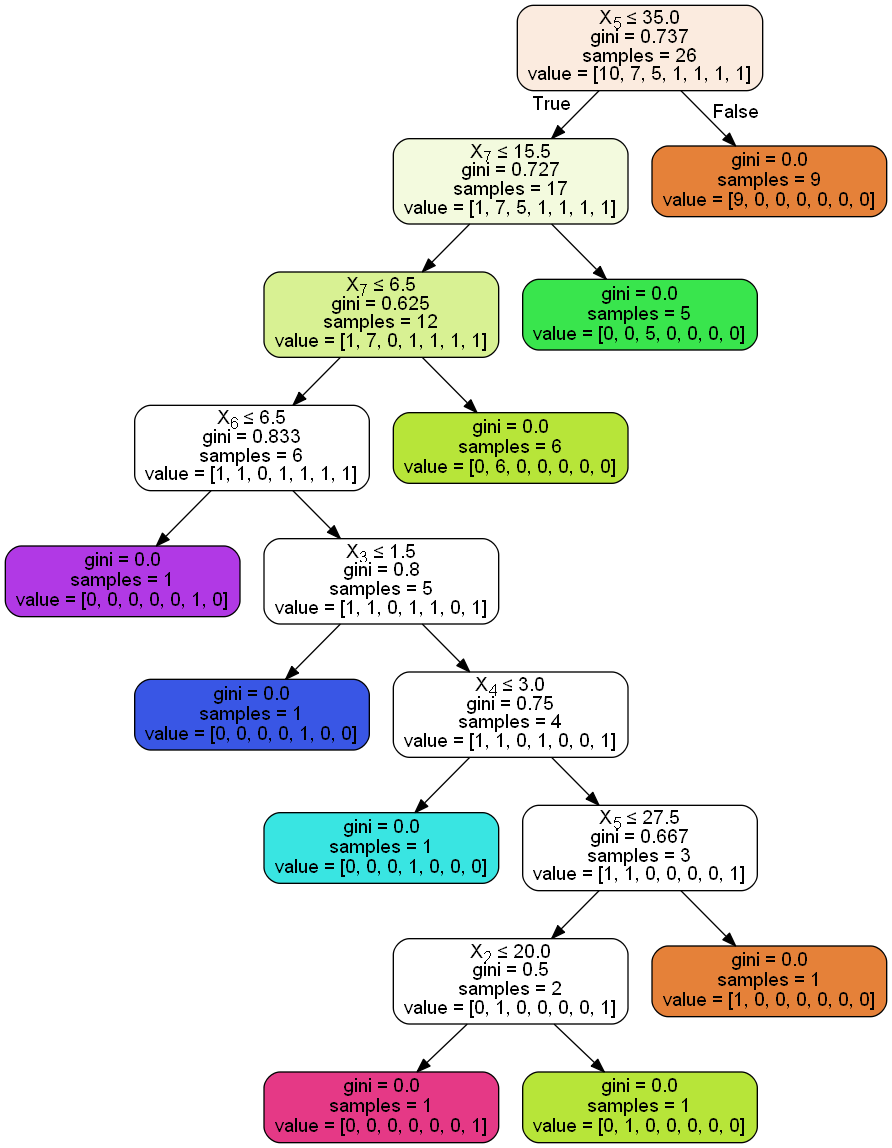

In [69]:
dot_data = StringIO()

export_graphviz(dtree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png())

#plt.tight_layout()

#plt.savefig('Macumber_Coursera_Capstone_Figure03.png') # has to be before plt.show()

Figure 3 shows the decision tree output. Leaf Node 0 is made up of nine (out of ten) members of Cluster 0 that have “Professional & Other Places” greater than 35%. Leaf Node 1 is made up of all five members of Cluster 2 having “Travel & Transport” greater than 15.5%. Leaf Node 2 is comprised of six (out of seven) members of Cluster 1 with “Travel & Transport” greater than 6.5%. Leaf Node 3 is comprised of one member from Cluster 5 having less than 6.5% “Shop & Service”. Leaf Node 4 is comprised of one member from each of Cluster 0, 1, 3, 4 and 6 having “Shop & Service” greater than 6.5%.

Table 01 lists all the train stations including their location (City, Latitude, Longitude) and the number of each type of venue (i.e., parent category) within a five-minute walk (416 m). A total of 4168 venues were returned. There were 1662 venues associated with Ottawa stations (n = 12) and 2506 venues associated with Toronto stations (n = 14). Toronto stations had a greater number of venues on average (179 ± 41) compared to Ottawa stations (139 ± 41). Toronto stations had on average a greater number of “Food” and “Professional & Other Places” venues (32 ± 12 and 55 ± 27) than Ottawa stations (21 ± 12 and 31 ± 27). In total 393 unique categories were returned, with Toronto stations having 321 and Ottawa stations having 290. Toronto stations had on average a greater number of unique categories (83 ± 16) than Ottawa stations (66 ± 16) 
For Figure 1 venue counts for each station were converted to percent and grouped by category. Four categories did not exceed 10% (apart from outliers) at any station: “Outdoor & Recreation”; “Nightlife Spot”; “College & University”; and “Arts & Entertainment”. Both “Professional & Other Places” and “Shop & Service” venues had the greatest range of values, followed by “Travel & Transport” and “Food”. Several outliers were identified (black circles), but the majority fall within the range of other category distributions, apart from two extreme outliers in “Shops & Service” and “College & University”. Those two outlying stations were the only ones to exceed 55% in a single venue category.
Figure 02 shows the dendrogram of our complete linkage cluster analysis of the station venue category counts. The dashed grey line marks the cut-off resulting in seven clusters, four of which contain only a single member. Two of the single member clusters represent the two extreme outliers identified by the box plots.
Table 02 shows the venue counts for each station converted to percent and sorted by cluster and city. Table 03 is a summary of Table 02, showing the total number of stations in each cluster, the number of Ottawa and Toronto stations and the mean values for each venue category. More than 50% of Toronto stations are found in Cluster 0 (n = 7), while only three Ottawa stations are found in Cluster 0. Based on the averages I have highlighted the characteristic venue categories for each cluster. For example, Cluster 0 is defined by higher percentages of “Professional & Other Places”, while Cluster 5 is defined by very high “College & University”.
Figure 3 shows the decision tree output. Leaf Node 0 is made up of nine (out of ten) members of Cluster 0 that have “Professional & Other Places” greater than 35%. Leaf Node 1 is made up of all five members of Cluster 2 having “Travel & Transport” greater than 15.5%. Leaf Node 2 is comprised of six (out of seven) members of Cluster 1 with “Travel & Transport” greater than 6.5%. Leaf Node 3 is comprised of one member from Cluster 5 having less than 6.5% “Shop & Service”. Leaf Node 4 is comprised of one member from each of Cluster 0, 1, 3, 4 and 6 having “Shop & Service” greater than 6.5%.

For the most part the hierarchical cluster analysis and the decision tree model arrived at similar groupings. The decision tree model separated St-George Station from Cluster 0, Dundas Station from Cluster 1. Neither cluster analysis nor the decision tree model identified the possibility of St-George Station forming a cluster with uOttawa Station and Museum Station based on their high percentages of “College & University”. Nor did the analyses group St-Laurent Station and Queen Station based on their higher percentages of “Shop & Service”.
A significant portion of Toronto stations, twelve out of fourteen, fall within Cluster 0, 1 and 2 highlighting that stations with these proportions of venue categories are characteristic of well-established metro stations. An even mix of Ottawa and Toronto stations is seen in Cluster 1 and 2, both clusters are characterised by an even spread of “Food”, “Professional & Other Places” and “Shop & Service” venues, with Cluster 2 having elevated percentages of “Travel & Transport” venues.
Leaf Node 0 / Cluster 0 contained Stations with high percentages “Professional & Other Place” venues. Toronto stations formed the majority of Leaf Node/Cluster 0, with only three Ottawa stations present. This is also the case for Ottawa stations in general as Toronto stations had on average a greater number of “Professional & Other Places” venues (55 ± 27) than Ottawa stations (31 ± 27). This highlights a specific venue category in need of development for Ottawa stations in having a greater amount of “Professional & Other Place” venues located in proximity to them. 
Two extreme outliers that were comprised of a single dominant venue category were seen in the box plots and the cluster analysis. Seventy-three percent of St-Laurent Station venues are “Shops & Services” while 64% of uOttawa Station venues are “College & University”. These outliers are not surprising as St-Laurent is one of Ottawa’s larger shopping malls and the University of Ottawa is Ottawa’s largest University. Yet this lack of diversity in venue category types at these stations may highlight an opportunity for an increase in other venue category types (e.g., Food, Professional & Other Services) so that the proportion of venue types approaches those of Cluster 0, 1 and 2, in which the majority of Toronto Stations cluster into.
The hierarchical cluster analysis also identified another station that formed its own cluster, Museum Station in Cluster 6. It is characterised by relatively high percent (24%) of “Arts & Entertainment” venues. The closest Ottawa station is Pimisi Station with 15% of its venues being “Arts & Entertainment”. The lack of an Ottawa Station fitting this profile highlights the potential need for such a stop, perhaps during later phases of the light rail expansion a station could be placed closer to “Arts & Entertainment” venues.


The assumption of this study is that Toronto Stations, representing an older and more established metro system, have had time to develop and showcase the typical configuration of venue types at metro stations. Indeed, most Toronto Stations were characterised by even levels of “Food”, “Professional & Other Services” and “Shops & Service” venues, with one cluster having elevated percentages of “Professional & Other Services”. By comparing Ottawa stations to the Toronto stations, we can investigate whether there is room for development in the venue types. In a few cases, Ottawa stations showed a lack of diversity of venue types, being dominated by a single type. This represents an opportunity to increase other types of venues at these stations. Representing a valuable target for entrepreneurs looking for suitable business locations.